# Tree rings analysis in LSST sensors

In [1]:
!pip install sep
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'hot')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
rcParams = plt.rcParams.copy()

import numpy as np
import posixpath, glob, datetime, os, sys

from astropy.io import fits as pyfits

import sep
import cv2

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

/tmp/ipykernel_26787/1011429305.py:23: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Code from David Kirkby 
https://github.com/dkirkby/AstroCCD/blob/master/LabData.ipynb

In [3]:
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask

def measure_profile(data, mask, line_start, line_stop, sigma=50, num_bins=50):
    """Measure a 1D profile along a line through 2D data.
    
    The sigma parameter determines the effective width of the measurement line
    in units of pixels, and is used to apply Gaussian weights as a function of
    transverse distance from the line. Returns a pair of functions to draw the
    measurement line and measured profile.
    """
    x1, y1 = line_start
    x2, y2 = line_stop
    dx, dy = x2 - x1, y2 - y1
    dr = np.sqrt(dx ** 2 + dy ** 2)
    
    # Calculate the rotation angle that puts the line along +x.
    th = np.arctan2(dy, dx)
    sin_th, cos_th = np.sin(th), np.cos(th)
    
    # Calculate pixel distances relative to the line.
    ny, nx = data.shape
    x, y = np.arange(nx), np.arange(ny)[:, np.newaxis]    
    u = (cos_th * (x - x1) + sin_th * (y - y1))
    v = (-sin_th * (x - x1) + cos_th * (y - y1))
    
    # Use Gaussian weighting in the transverse direction.
    wgt = np.exp(-0.5 * (v / sigma) ** 2)
    M = mask & (u >= 0) & (u <= dr)

    # Calculate the 1D profile histogram.
    D = u[M].reshape(-1)
    W1 = data[M].reshape(-1)
    W2 = wgt[M].reshape(-1)
    profile, edges = np.histogram(D, bins=num_bins, range=(0, dr), weights=W1 * W2)
    wsum, edges = np.histogram(D, bins=num_bins, range=(0, dr), weights=W2)
    profile /= wsum
    centers = edges[1:] - 0.5 * dr / num_bins
    ymax = 1.1 * np.max(np.abs(profile))
    
    # Draw the measurement line on scaled axes. The width indicates +/-sigma.
    corners = np.array([[0, -sigma], [0, +sigma], [dr, +sigma], [dr, -sigma]])
    R = np.array([[cos_th, sin_th], [-sin_th, cos_th]])
    corners = corners.dot(R)
    corners += [x1, y1]
    def draw_line(axes, scale):
        poly = matplotlib.patches.Polygon(
            corners / scale, fc='w', ec='k', alpha=0.75)
        axes.add_patch(poly)

    # Profile has x units of pixels and y units of ADU. Axis values are not
    # drawn but grid line spacing is fixed at the specified values.
    def draw_profile(axes, xgrid=10, ygrid=2):
        print ('Profile grid spacing is {0} pixels, {1} ADU.').format(xgrid, ygrid)
        axes.plot(centers, profile, 'k.-')
        axes.set_xlim(0, dr)
        axes.set_ylim(-ymax, +ymax)        
        axes.set_xticks(np.arange(0, dr, xgrid))
        ygrid = np.arange(ygrid, ymax, ygrid)
        axes.set_yticks(np.hstack((-ygrid[::-1], ygrid)))
        axes.grid(c='b', ls='-', alpha=0.5)
        axes.axhline(0, c='r', ls='-', lw=2)
        # This removes the axis labels but not the space they occupied.
        axes.xaxis.set_ticklabels([])
        axes.yaxis.set_ticklabels([])
        
    return draw_line, draw_profile

## My own code

In [4]:
def get_diff(image, size=64):
    bg = sep.Background(image.astype(np.double), bw=size, bh=size)
    diff = (image-bg.back())/bg.back()

    return diff

def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1/image
    else:
        diff = apply_filter(image, size, power=power)
    
        return diff/image

def apply_to_blocks(image, fn, geometry=(2,8)):
    image1 = image.copy()

    v = view_as_blocks(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

    for _ in xrange(geometry[0]):
        for __ in xrange(geometry[1]):
            v[_,__] = fn(v[_,__])

    return image1

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)

def imshow(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if not 'vmin' in kwargs:
        kwargs['vmin'] = vmin1
    if not 'vmax' in kwargs:
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

### Testing on actual data

In [6]:
from lsst.daf.butler import Butler

repo_path = "/repo/ir2"
butler = Butler(repo_path,collections=['LSSTCam/raw/all'],instrument='LSSTCam')
registry = butler.registry

In [7]:
sensor="R01_S22"
list(registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id

8

In [8]:
where = "exposure.science_program = '13379' and detector=8 and exposure.exposure_time > 14."
refs = list(set(butler.registry.queryDatasets(
    'raw',
    where=where,
    collections='LSSTCam/raw/all')))

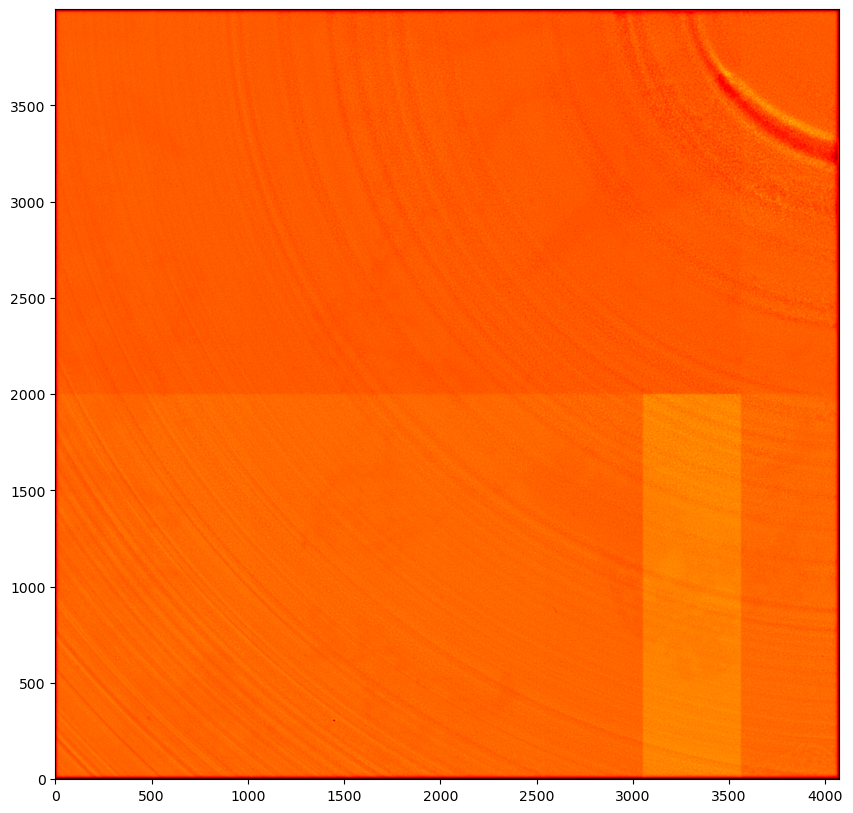

In [9]:
from lsst.ip.isr.isrTask import IsrTask

img = butler.get(refs[0])
isr = IsrTask()
isr.config.doLinearize=False
isr.config.doDark=False
isr.config.doBias=False
isr.config.doFlat=False
isr.config.doDefect=False
isr.config.overscan.fitType: 'MEDIAN_PER_ROW'
#isr.config.overscan.doParallelOverscan = True 
#isr.config.overscan.fitType: 'AKIMA_SPLINE'
#isr.config.overscan.fitType: 'MEAN'
postISRCCD = isr.run(img)

plt.imshow(postISRCCD.exposure.image.array)

/tmp/ipykernel_26787/3818982022.py:16: RuntimeWarning: divide by zero encountered in divide
  return diff/image


Text(0.5, 1.0, 'ITL-3800C-231, 0.15, red')

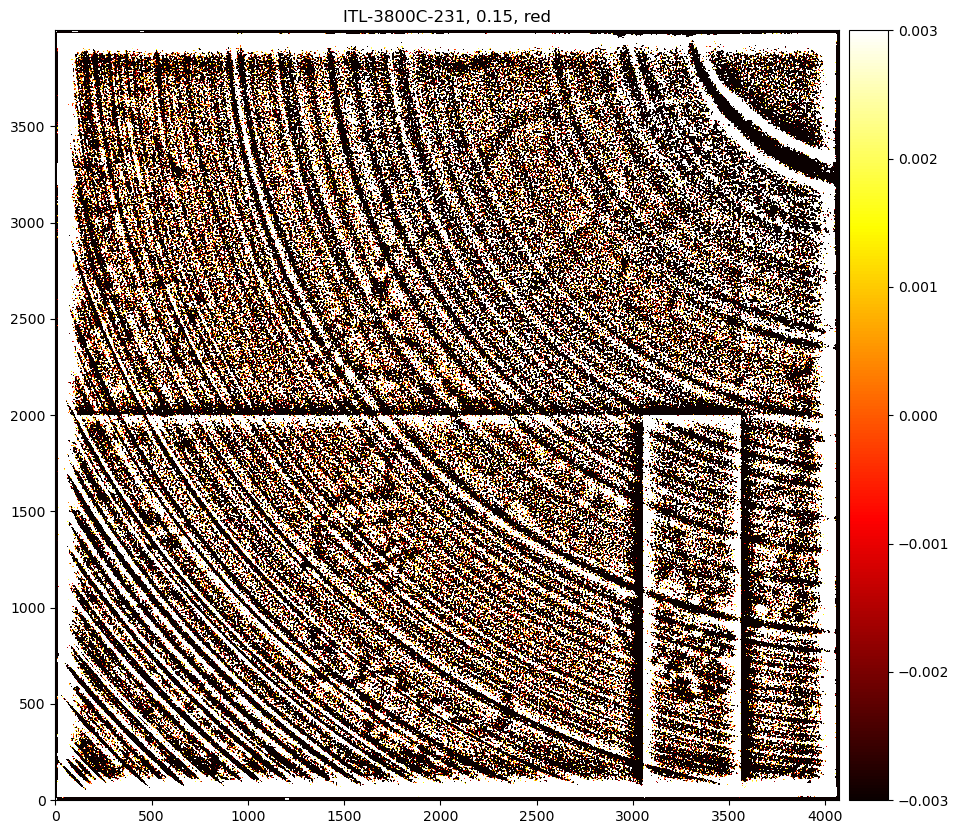

In [10]:
#image,header = pyfits.getdata(filename), pyfits.getheader(filename)

# diff = apply_to_blocks(image, lambda x:get_diff(x, size=128))
# diff = apply_to_blocks(image, lambda x:get_diff_lowpass(x, size=128))
image = postISRCCD.exposure.image.array
header = img.getMetadata()
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=False)

imshow(diff, interpolation='bicubic', vmin=-0.003, vmax=0.003)
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

### Preparing the image and masking artefacts

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

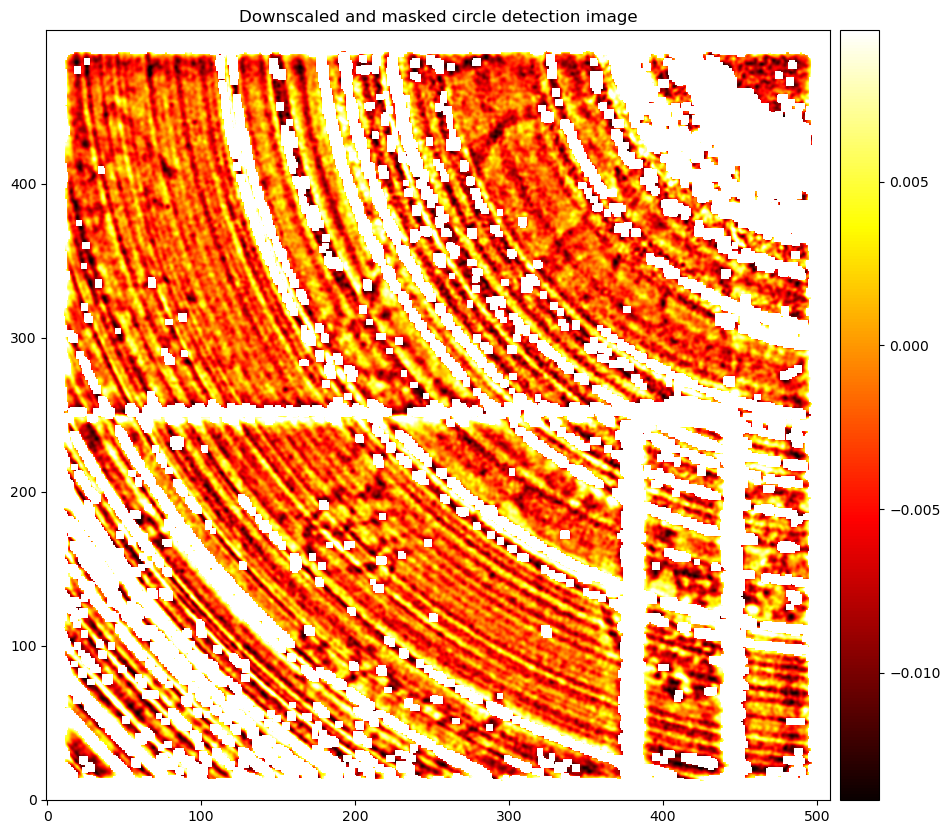

In [11]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
#threshold = 0.001 # For stronger rings
#threshold = 0.002 # For strongest rings
threshold = 0.002*8 # For strongest rings


diff1 = gaussian_filter(diff, 8.0)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.mean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.max)
diff2[mask2] = None

imshow(diff2, interpolation='bicubic')#, vmin=-0.005, vmax=0.005)
plt.title('Downscaled and masked circle detection image')

### Fitting for circular pattern center

In [12]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

extent = 100
# extent = 200 # For larger center displacement

cc = opt.differential_evolution(fn_detect, [[-extent,diff2.shape[1]+extent],[-extent,diff2.shape[0]+extent]], popsize=15)
print (cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print ("Original scale coordinates:", x0, y0)

 message: Optimization terminated successfully.
 success: True
     fun: -0.004261782881395634
       x: [ 5.281e+02  5.135e+02]
     nit: 15
    nfev: 483
Original scale coordinates: 4224.670662906685 4108.264735634008


### Diagnostic plots

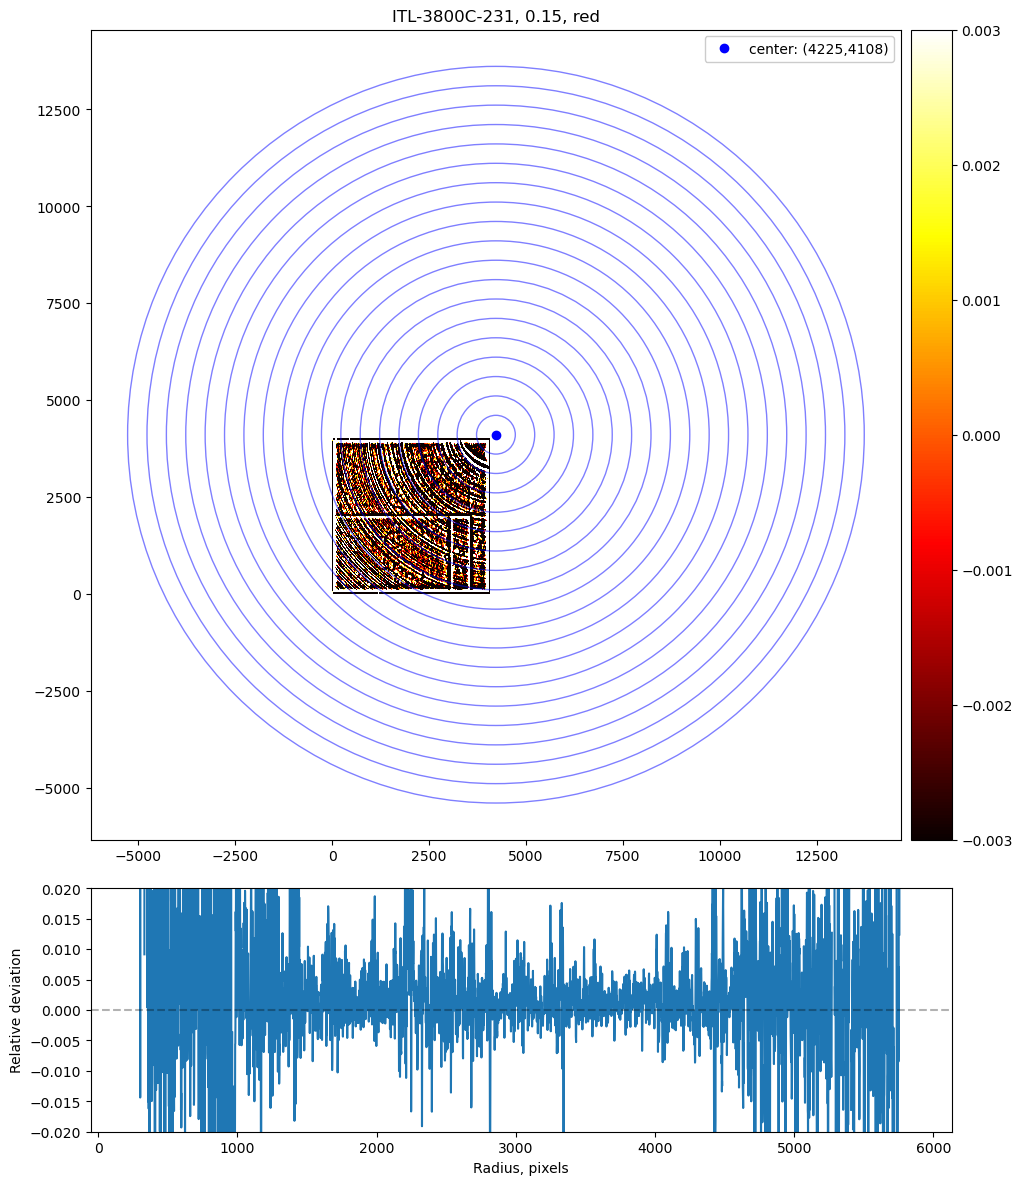

In [13]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, interpolation='bicubic', vmin=-0.003, vmax=0.003)
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 10000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.show()

# Now make less restrictive mask
mask = np.abs(diff1) > 0.002

pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')
# plt.subplot(211)
plt.subplot2grid((4,1),(3,0), rowspan=1)

plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['BSSVBS'], header['CCOBLED']))
plt.ylim(-0.02, 0.02)
plt.tight_layout()

(5000.0, 6000.0)

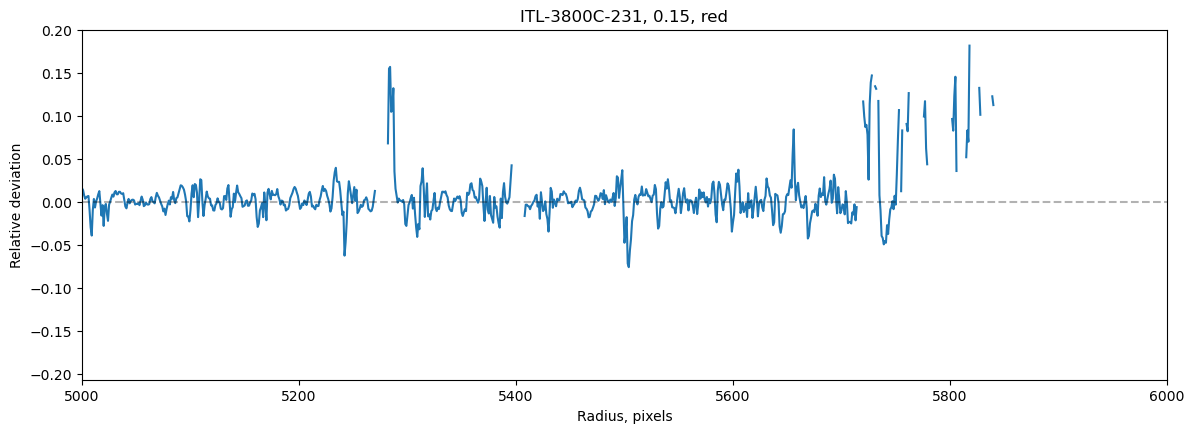

In [14]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")
# plt.ylim(-0.002, 0.002)
plt.xlim(5000,6000)

### Periodogram

Will analyse the following radial interval: 1407 - 5714 pixels


/tmp/ipykernel_26787/3563988134.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0/freq, power, '-')


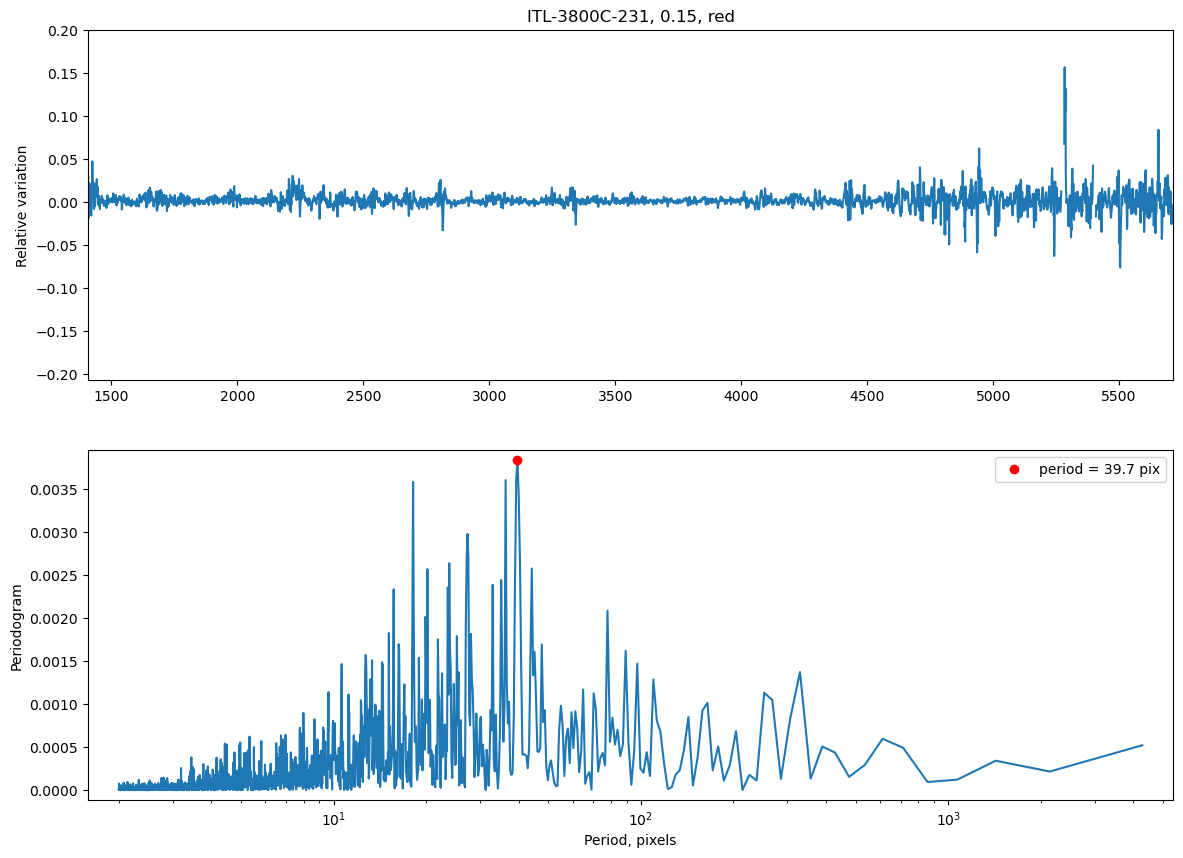

In [15]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
print ("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

### Dynamic power spectrum

Text(0.5, 1.0, 'Unnormalized power vs time, 500 pix window')

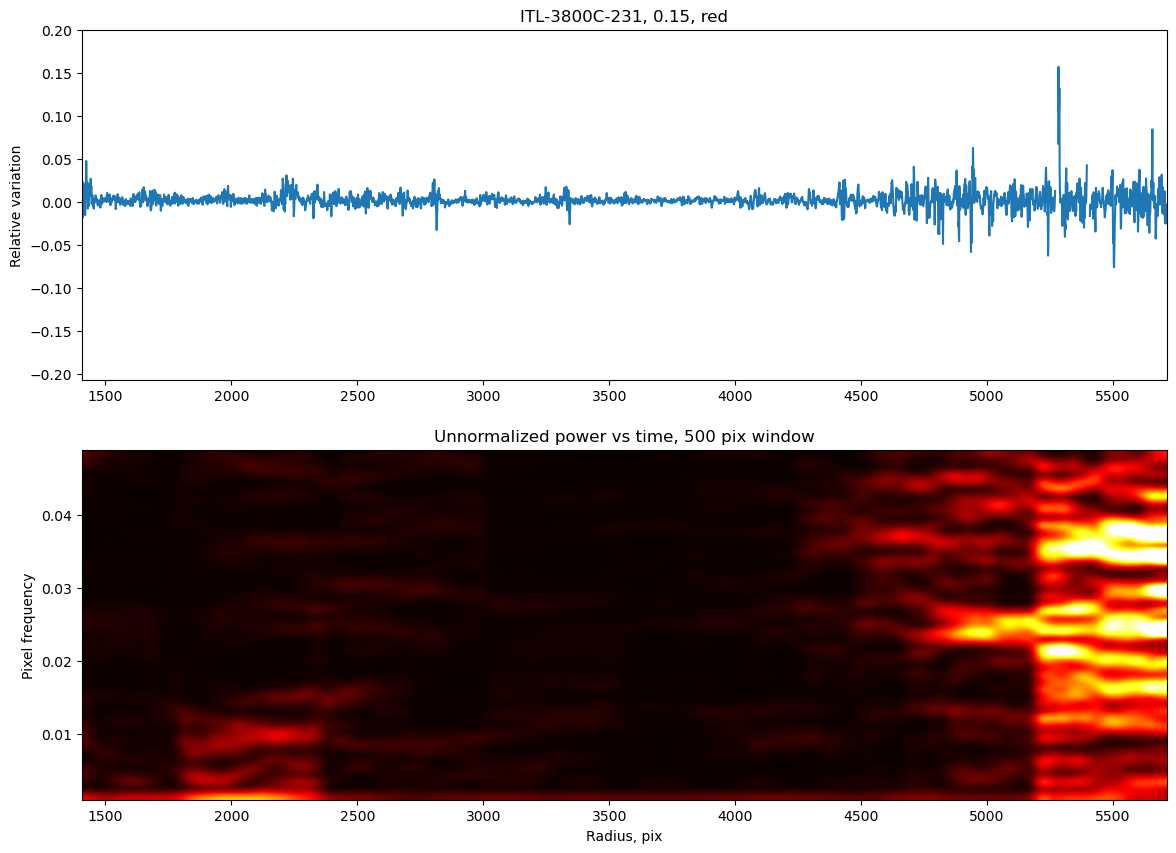

In [16]:
dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
freq = np.arange(1e-3, 0.5e-1, 1e-3)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
#     freq,power = periodogram(v[idx], fs=1.0/5)
    power = lombscargle(pos[idx], v[idx], 2*np.pi*freq, normalize=False, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,freq[0],freq[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Pixel frequency')
plt.title('Unnormalized power vs time, %g pix window' % window)

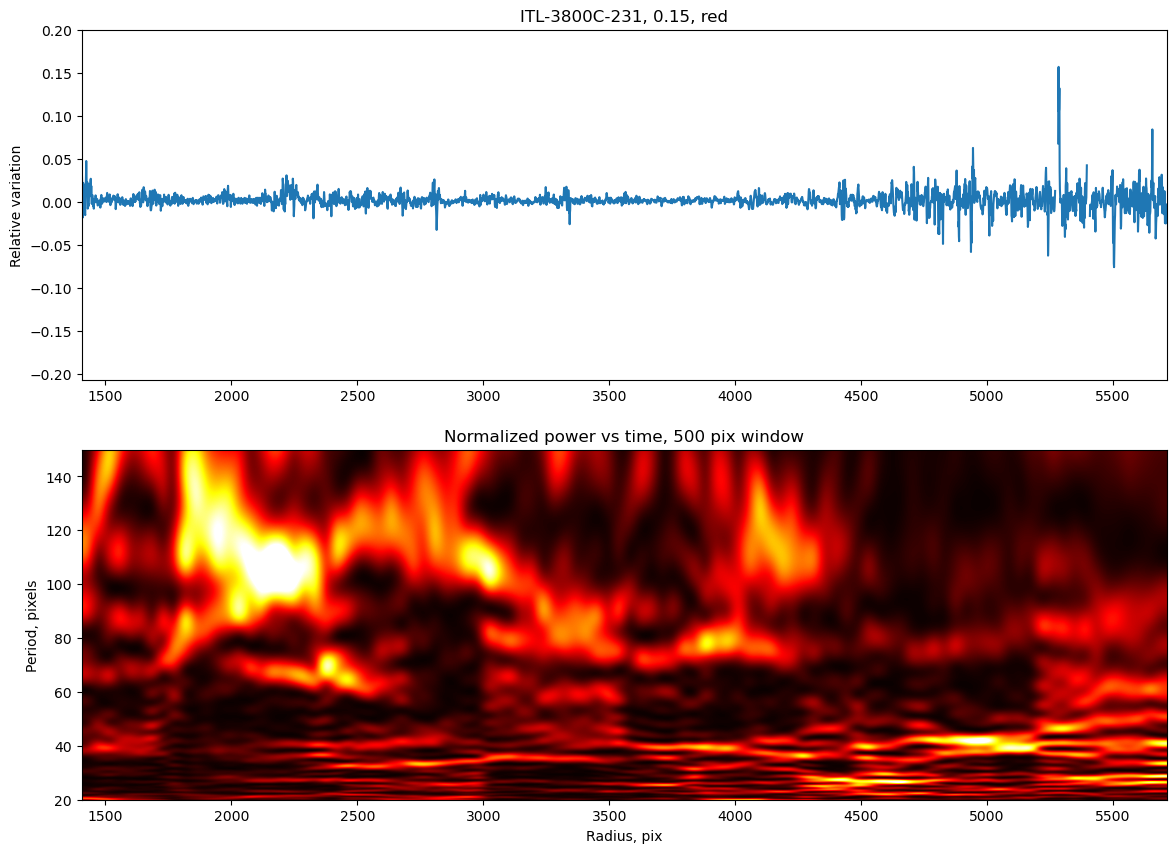

In [17]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 150.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')

### Amplitude vs Radius

/tmp/ipykernel_26787/3189899638.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


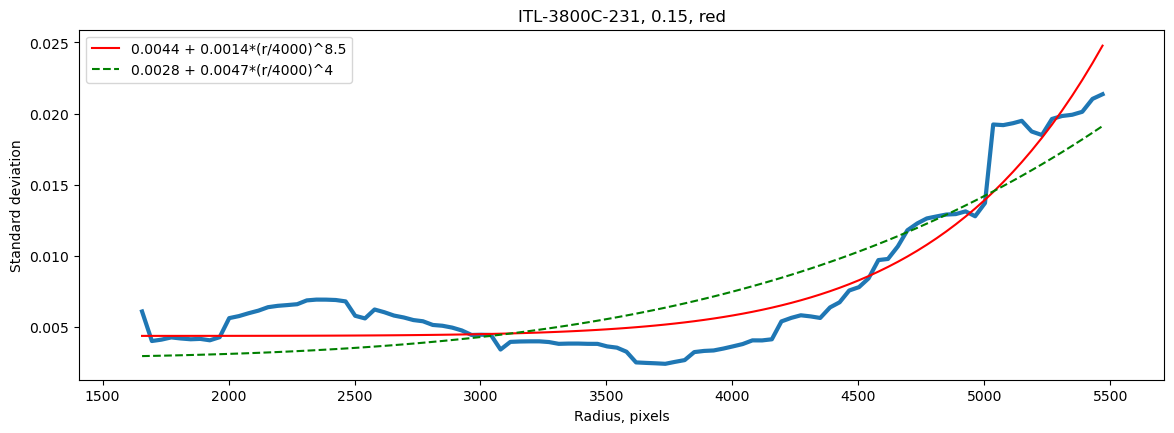

In [18]:
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

#mids,stds = [np.array(_) for _ in mids,stds]

stds=numpy.array(stds)
mids=numpy.array(mids)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title(f"{header['LSST_NUM']}, {header['BSSVBS']}, {header['CCOBLED']}")

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)